In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
import env

In [2]:
sql_url = env.get_connection('zillow')

In [3]:
query = '''
        SELECT
    prop.*,
    predictions_2017.logerror,
    predictions_2017.transactiondate,
    air.airconditioningdesc,
    arch.architecturalstyledesc,
    build.buildingclassdesc,
    heat.heatingorsystemdesc,
    landuse.propertylandusedesc,
    story.storydesc,
    construct.typeconstructiondesc
FROM properties_2017 prop
JOIN (
    SELECT parcelid, MAX(transactiondate) AS max_transactiondate
    FROM predictions_2017
    GROUP BY parcelid
) pred USING(parcelid)
JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid
                      AND pred.max_transactiondate = predictions_2017.transactiondate
LEFT JOIN airconditioningtype air USING (airconditioningtypeid)
LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid)
LEFT JOIN buildingclasstype build USING (buildingclasstypeid)
LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid)
LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid)
LEFT JOIN storytype story USING (storytypeid)
LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid)
WHERE prop.latitude IS NOT NULL
  AND prop.longitude IS NOT NULL
  AND transactiondate <= '2017-12-31'
        '''

Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?
<br>

Answer those questions through a mix of statistical tests and visualizations.

In [4]:
df = pd.read_sql(query, sql_url)
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037124e+13,0.006940,2017-01-01,Central,None,None,Central,Condominium,None,None


In [12]:
def split_zillow(df):
    '''
    This function takes in the dataframe
    and splits it into train, validate, test datasets
    '''   
    # train/validate/test split
    train_validate, test = train_test_split(df, test_size=0.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=0.3, random_state=123)


    return train, validate, test

In [14]:
train, validate, test = split_zillow(df)

train.shape, validate.shape, test.shape

((43332, 68), (18572, 68), (15476, 68))

In [7]:
def overview(df):
    '''
    print shape of DataFrame, .info, and .describe
    parameters: single pandas dataframe, df
    return: none
    '''
    print('--- Shape: {}'.format(df.shape))
    print('_________________________________')
    print('--- Info')
    df.info()
    print('_________________________________')
    print('--- Column Descriptions')
    print()
    print(df.describe())

In [15]:
overview(train)

--- Shape: (43332, 68)
_________________________________
--- Info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43332 entries, 14505 to 54422
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            43332 non-null  int64  
 1   parcelid                      43332 non-null  int64  
 2   airconditioningtypeid         13989 non-null  float64
 3   architecturalstyletypeid      112 non-null    float64
 4   basementsqft                  26 non-null     float64
 5   bathroomcnt                   43332 non-null  float64
 6   bedroomcnt                    43332 non-null  float64
 7   buildingclasstypeid           6 non-null      float64
 8   buildingqualitytypeid         27958 non-null  float64
 9   calculatedbathnbr             42982 non-null  float64
 10  decktypeid                    332 non-null    float64
 11  finishedfloor1squarefeet      3332 non-null   flo

In [16]:
for column in train.columns:
    print(column)
    print(train[column].value_counts())
    print('\n_____________________________\n')

id
1892640    1
2351046    1
2965292    1
898801     1
2005928    1
          ..
1065272    1
2403700    1
1860142    1
229312     1
44315      1
Name: id, Length: 43332, dtype: int64

_____________________________

parcelid
14710878    1
12988766    1
14466969    1
11514869    1
12378776    1
           ..
12204053    1
11102527    1
13890485    1
11948653    1
14003519    1
Name: parcelid, Length: 43332, dtype: int64

_____________________________

airconditioningtypeid
1.0     13015
13.0      835
5.0        97
11.0       29
9.0        13
Name: airconditioningtypeid, dtype: int64

_____________________________

architecturalstyletypeid
7.0     96
8.0      9
2.0      3
3.0      2
21.0     2
Name: architecturalstyletypeid, dtype: int64

_____________________________

basementsqft
273.0     2
515.0     2
204.0     1
640.0     1
300.0     1
900.0     1
126.0     1
224.0     1
669.0     1
280.0     1
912.0     1
100.0     1
645.0     1
352.0     1
254.0     1
252.0     1
600.0     1
786.0

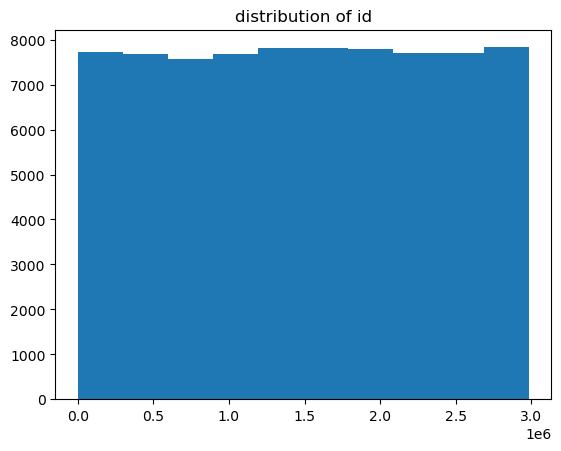

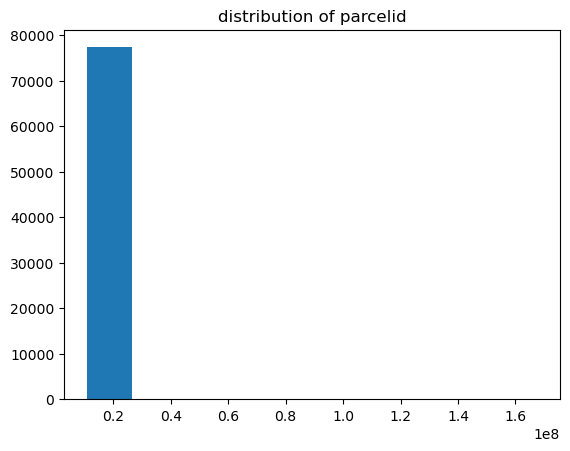

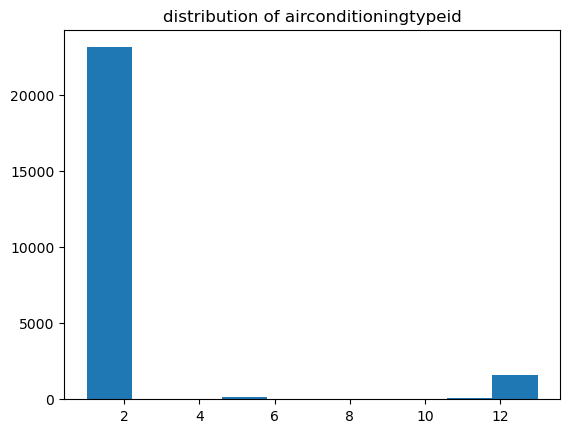

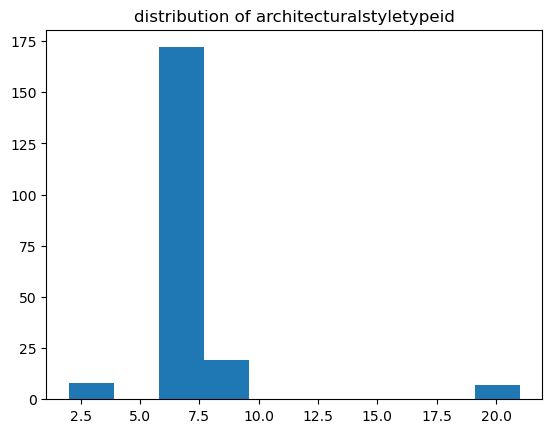

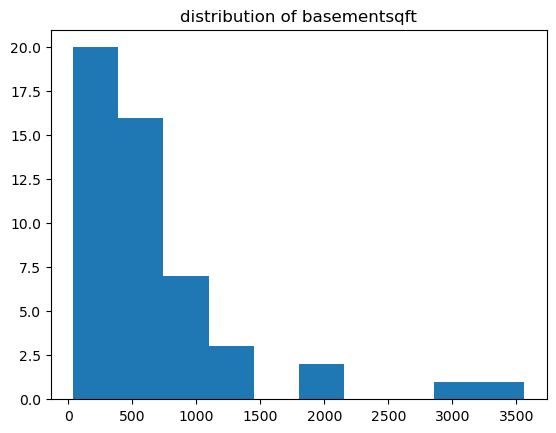

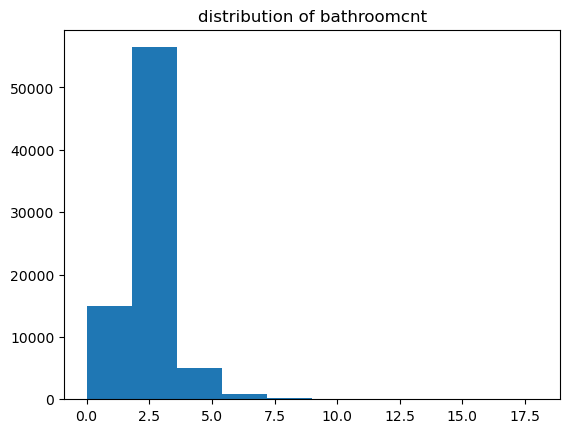

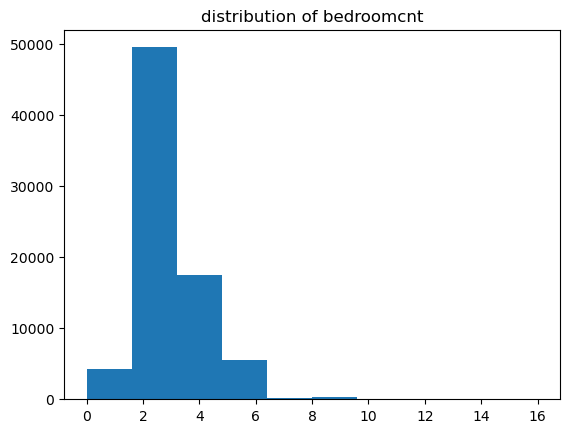

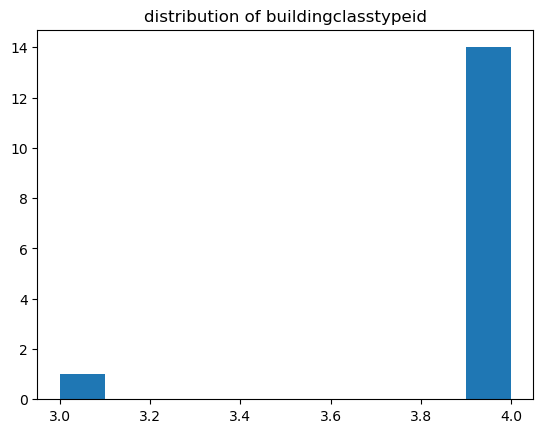

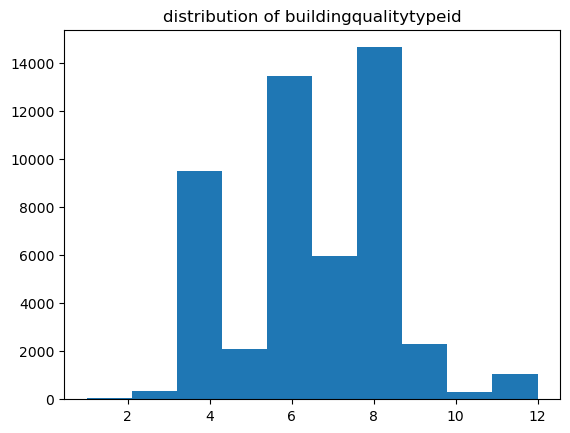

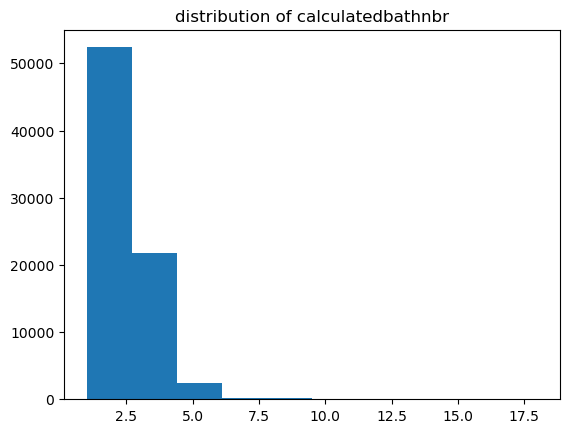

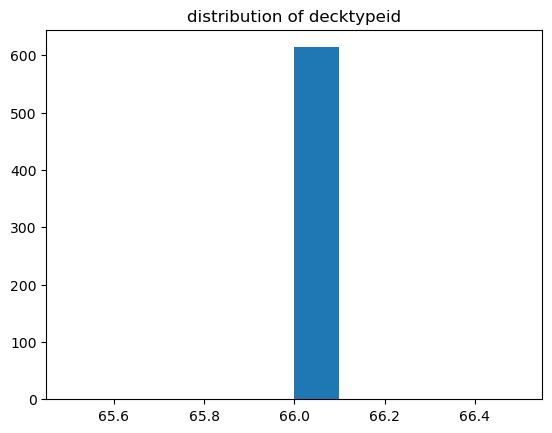

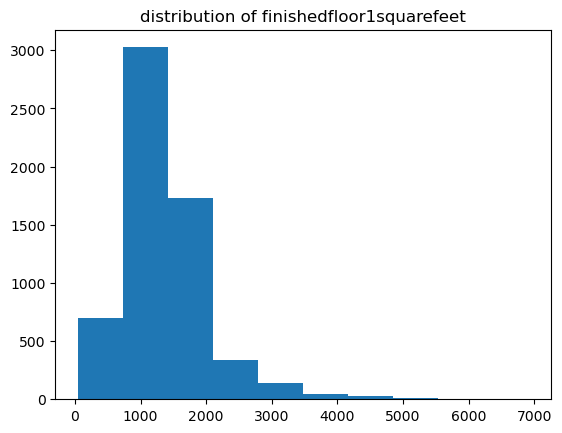

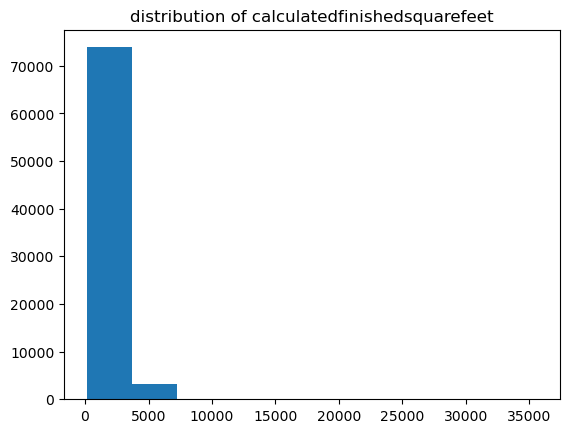

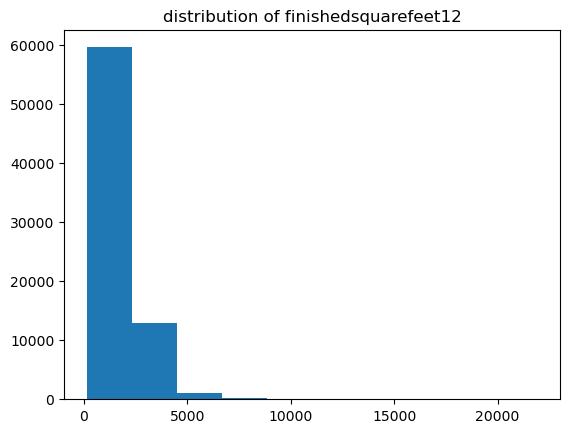

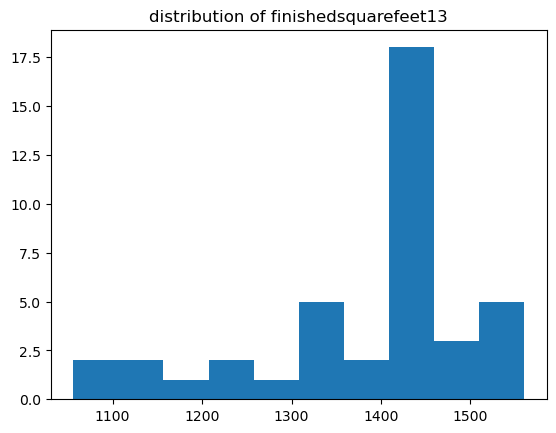

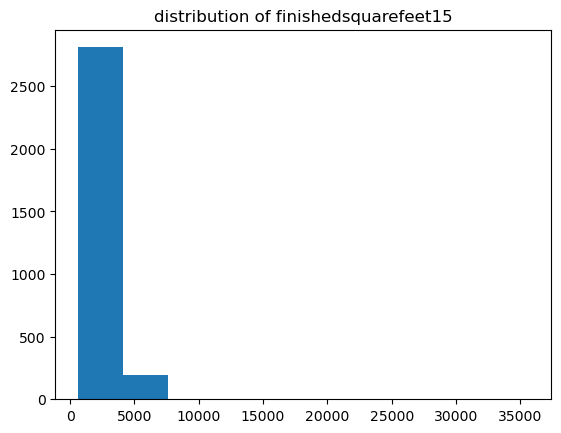

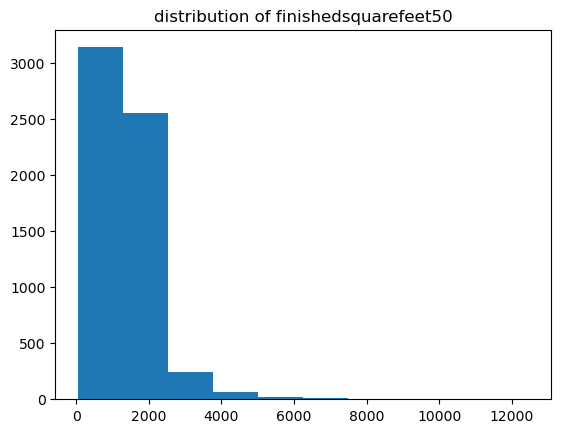

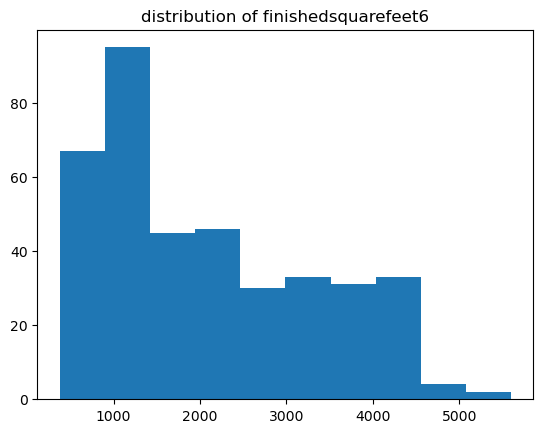

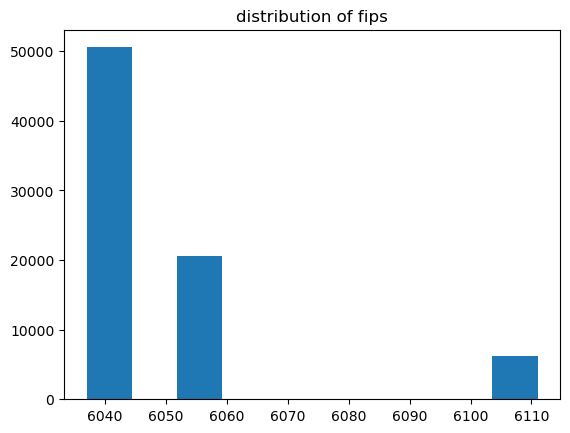

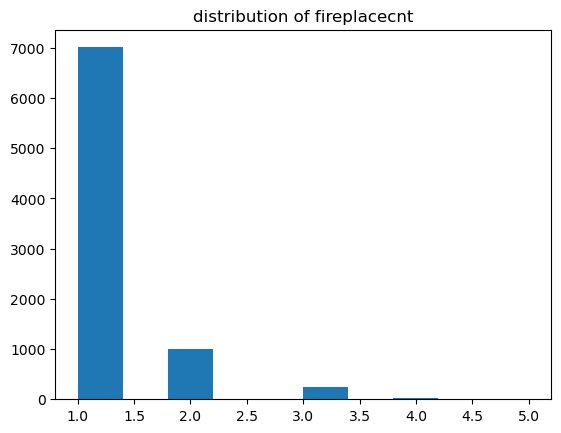

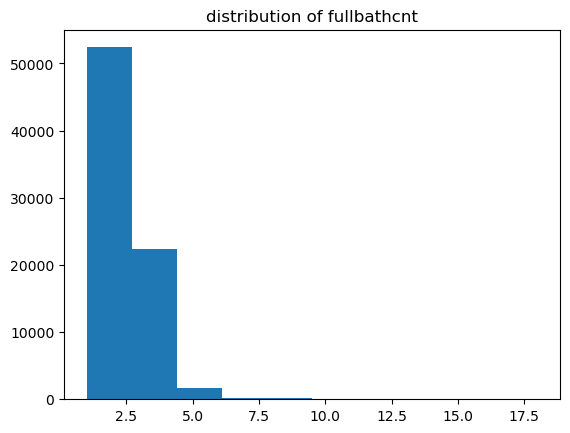

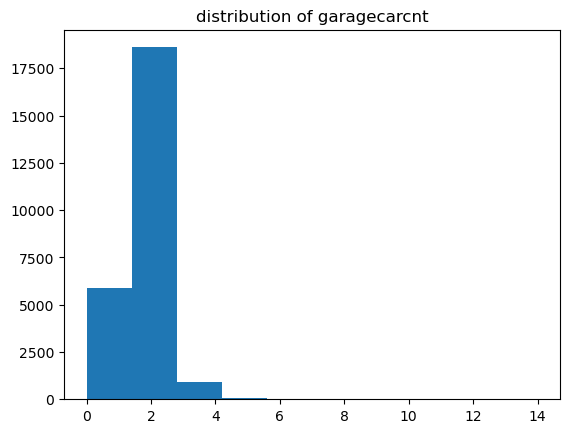

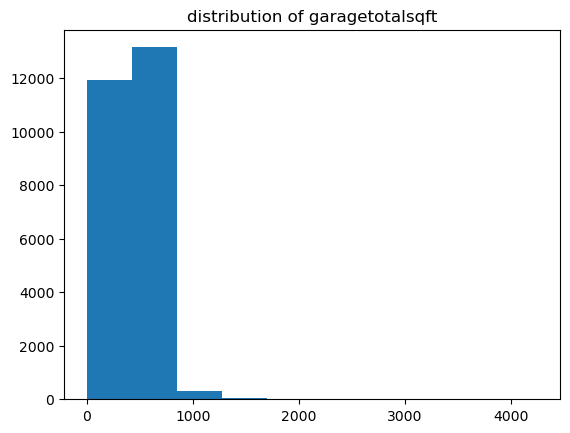

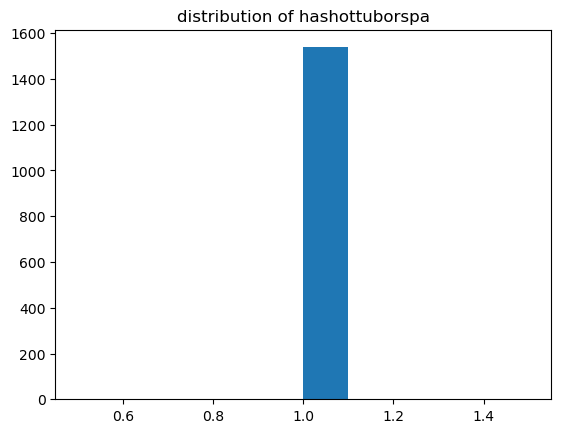

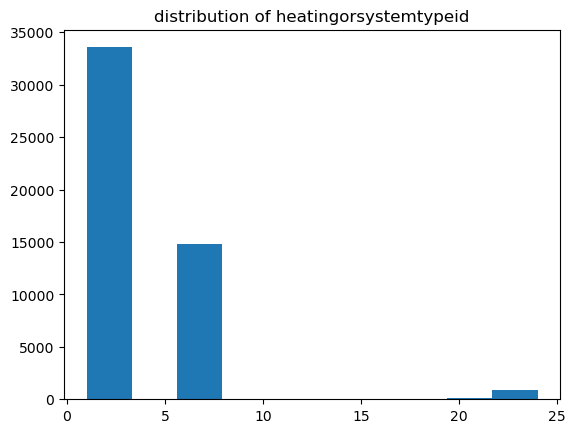

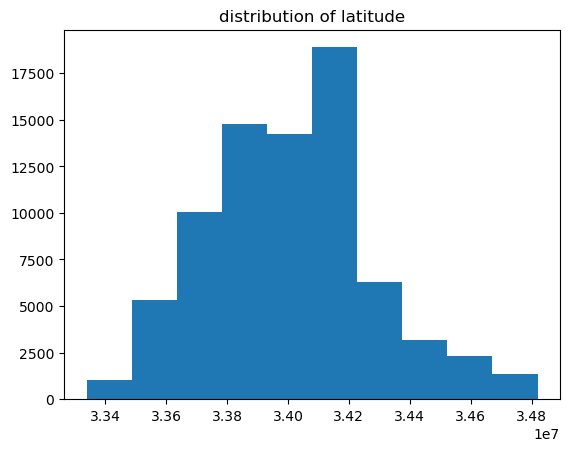

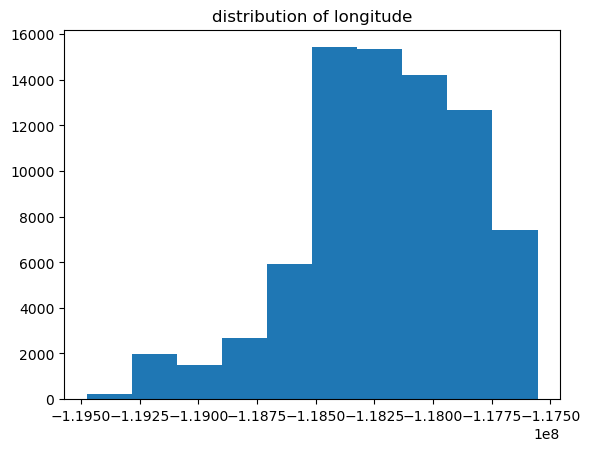

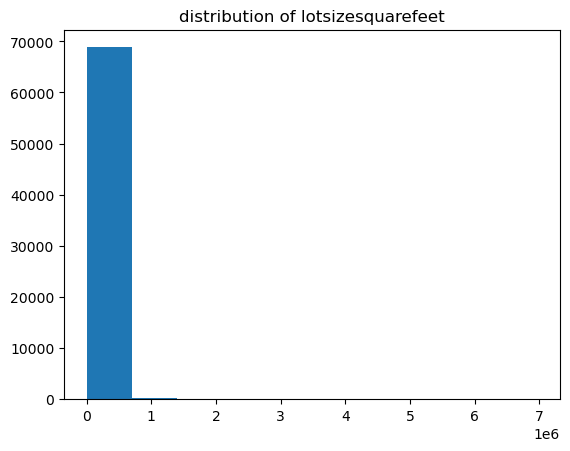

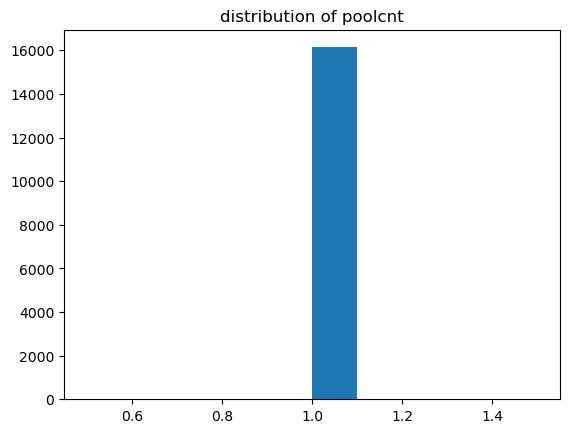

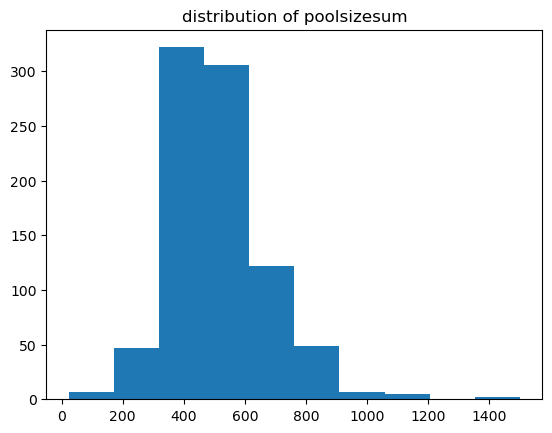

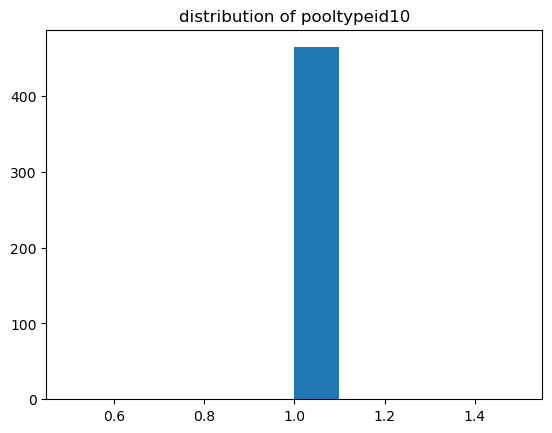

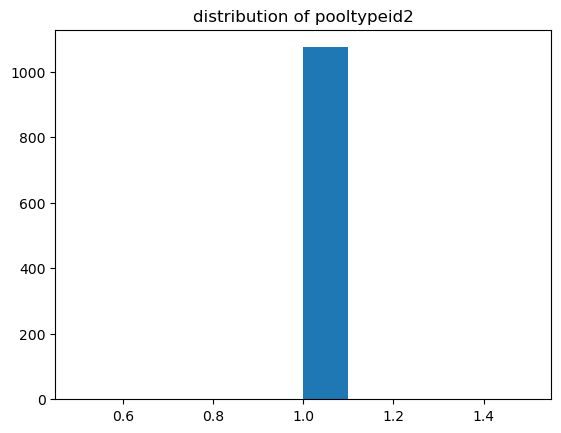

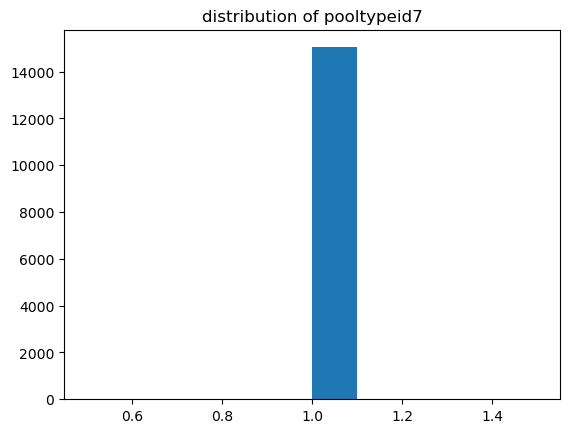

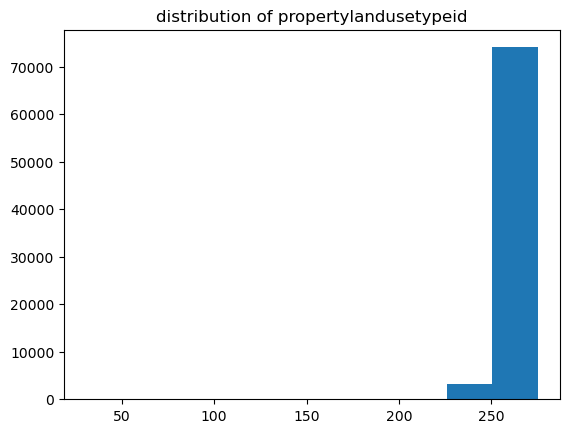

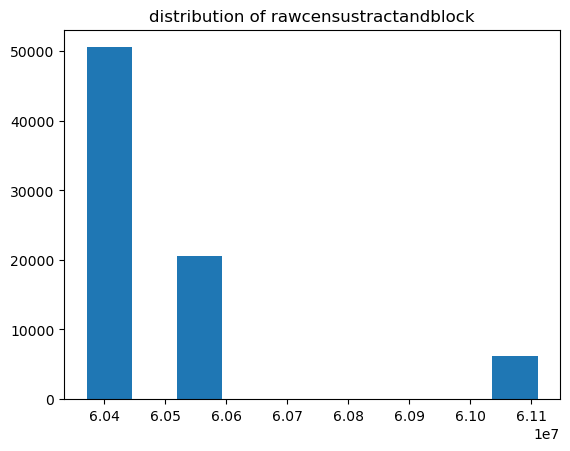

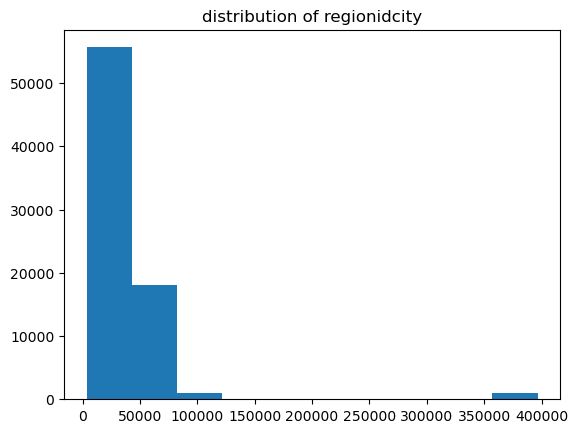

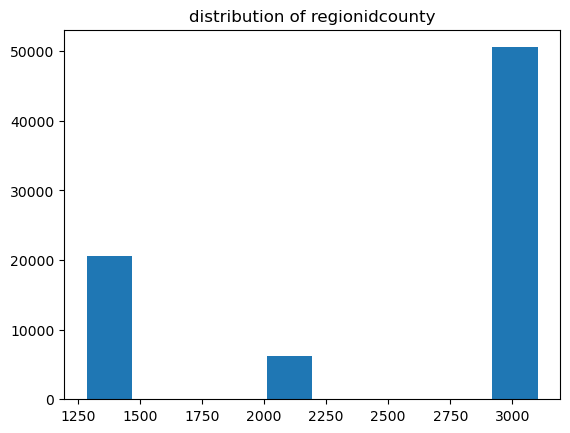

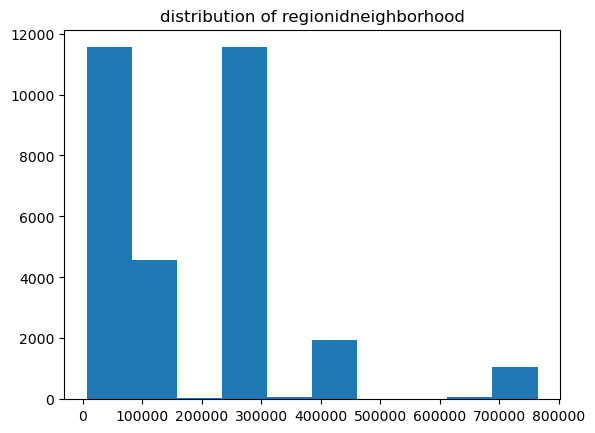

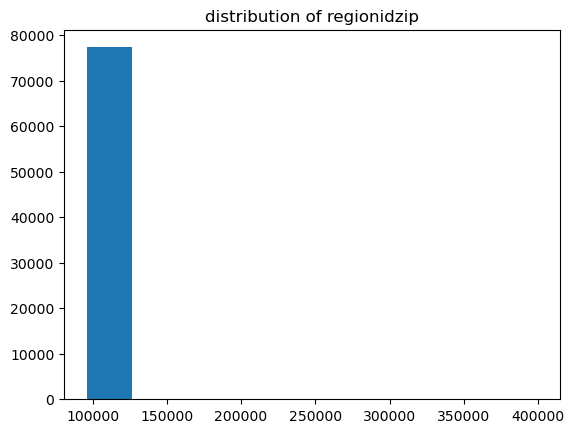

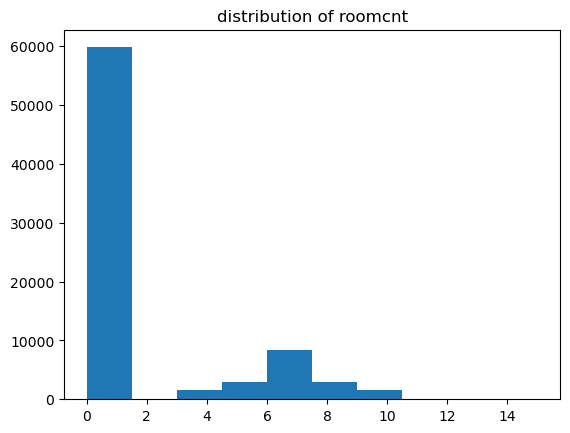

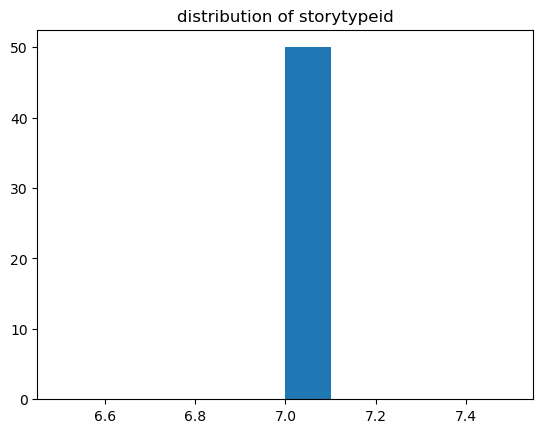

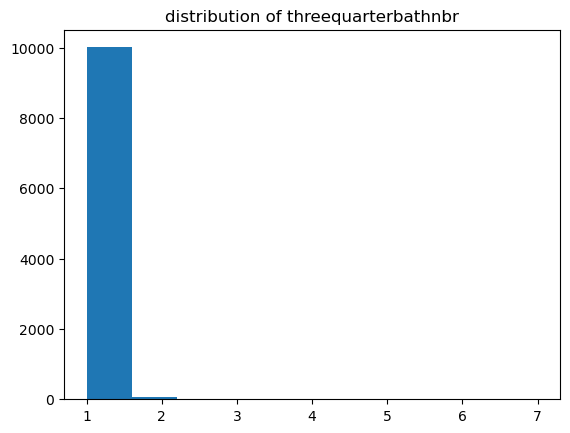

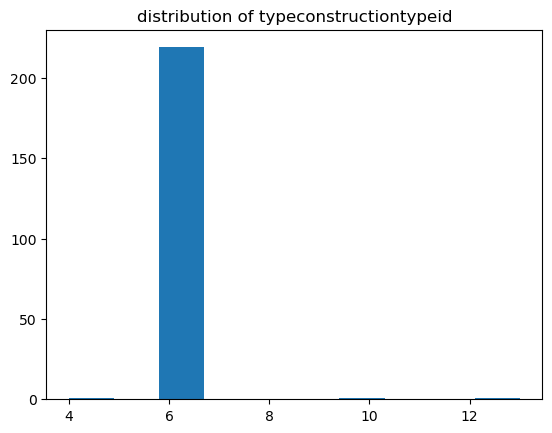

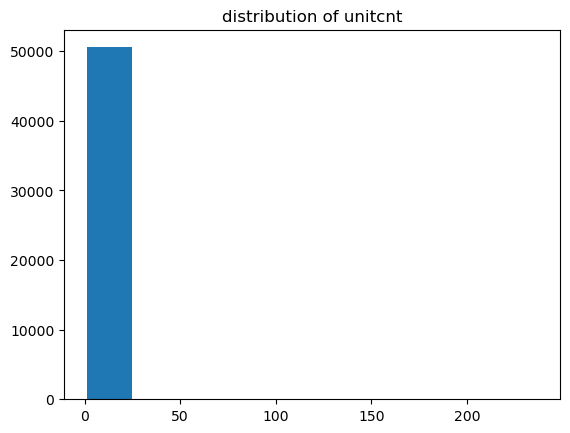

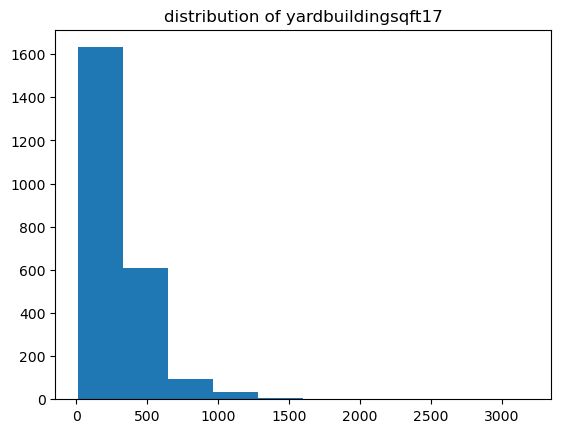

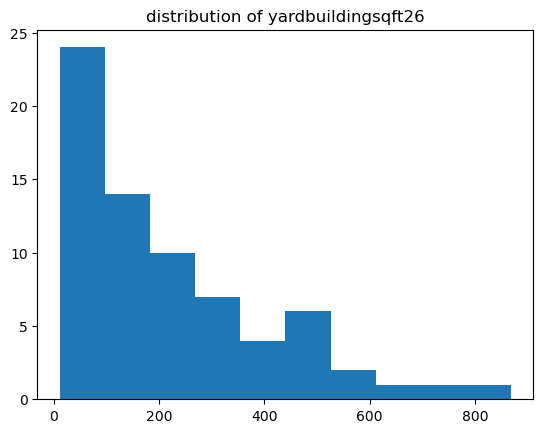

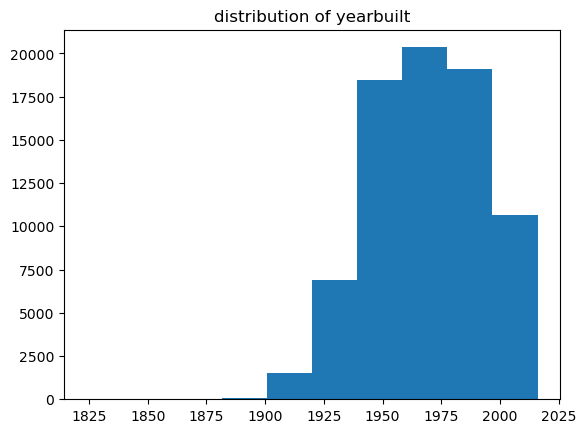

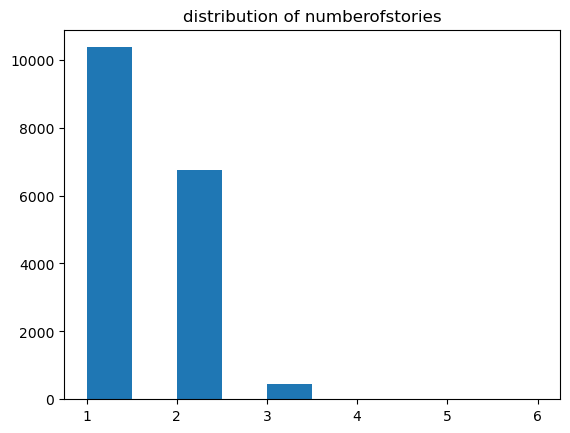

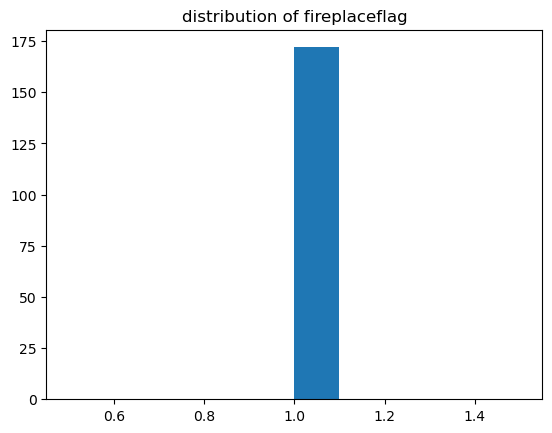

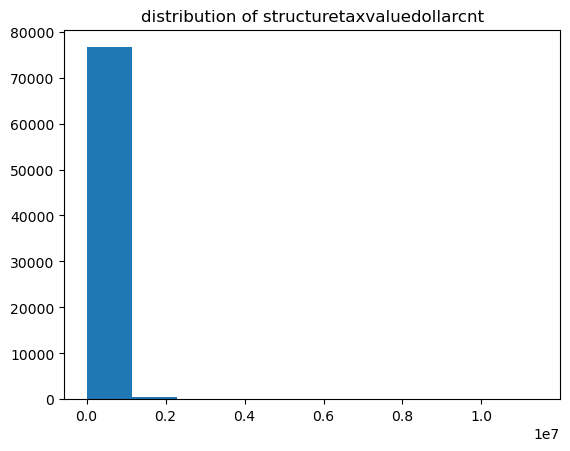

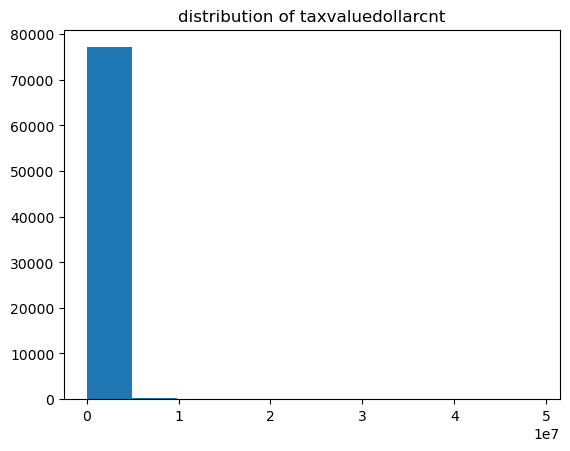

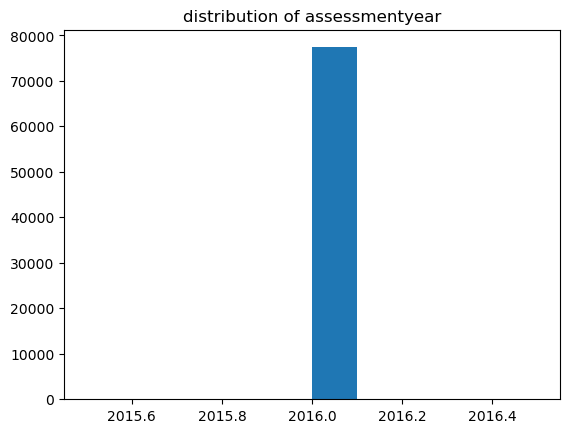

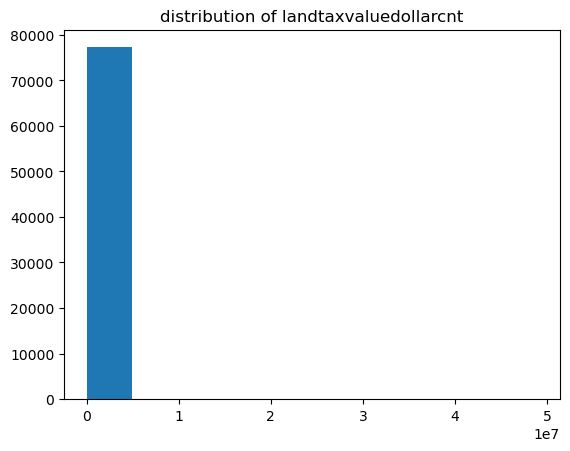

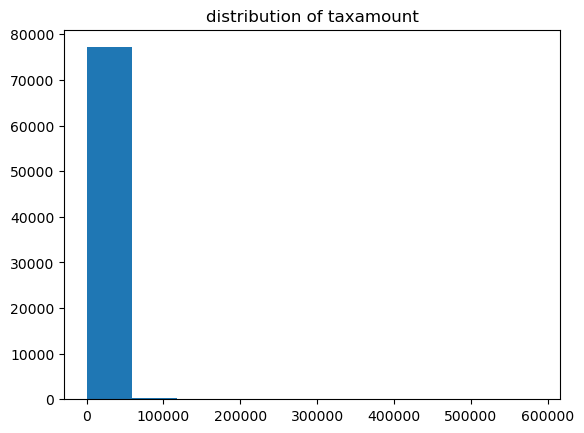

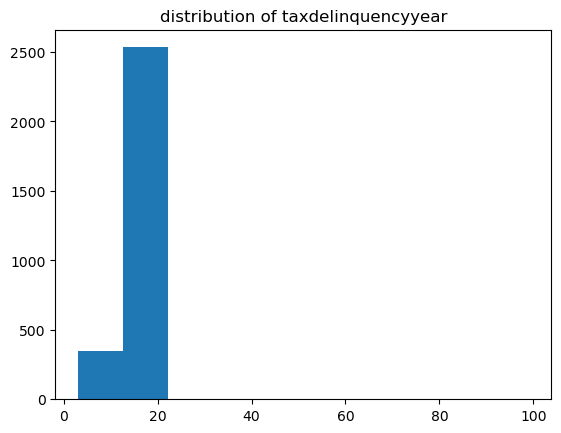

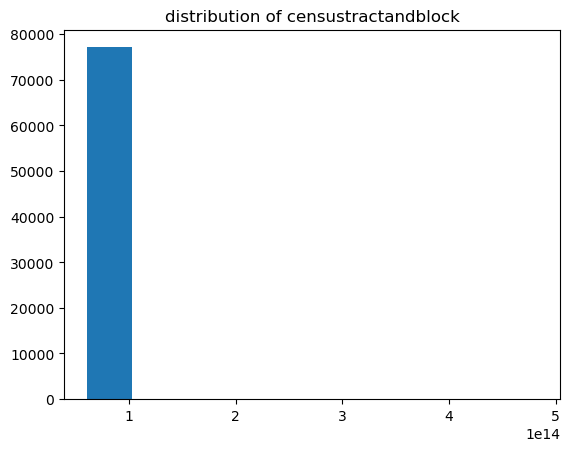

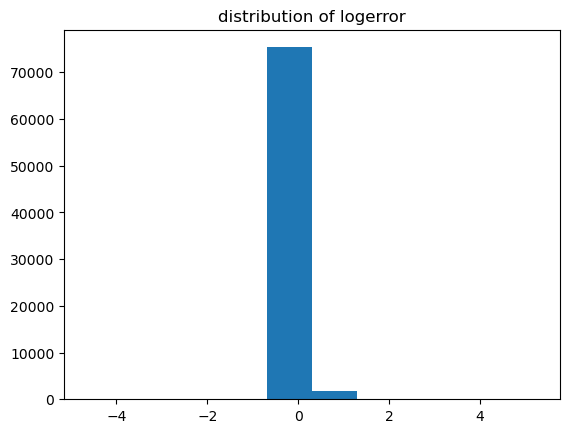

In [11]:
# make a list of numerical columns and use for loop for histograms
num_cols = list(df.select_dtypes(exclude=object).columns.values)

for col in num_cols:
    
    plt.hist(df[col])
    plt.title(f'distribution of {col}')
    plt.show()

### Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

Text(0.5, 1.0, 'Is logerror different for each County?')

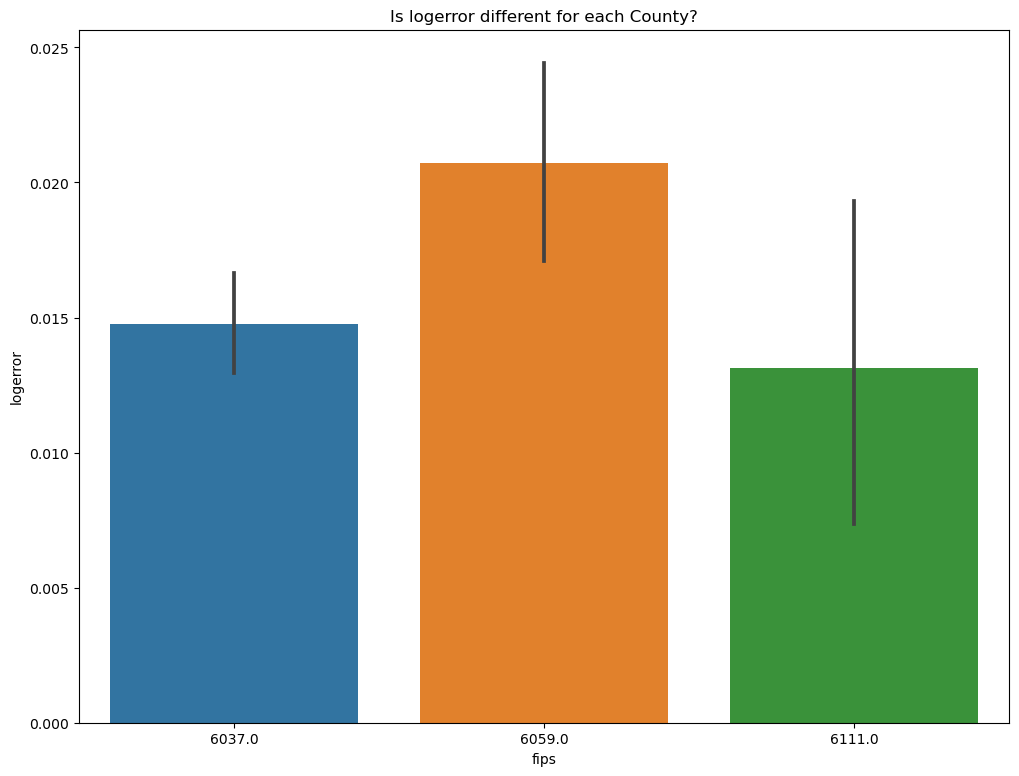

In [26]:
plt.figure(figsize=(12, 9))

sns.barplot(data = train, x = 'fips', y = 'logerror')
plt.title('Is logerror different for each County?')

### Are logerror and bedrooms correlated?

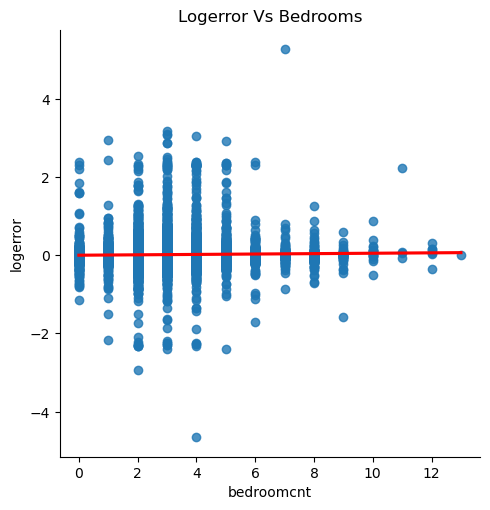

In [32]:
sns.lmplot(x='bedroomcnt', y='logerror', data=train, scatter=True, line_kws={'color': 'red'})
plt.title('Logerror Vs Bedrooms')
plt.show()

### Are logerror and bathrooms correlated?

In [44]:
corr, p = stats.pearsonr(train.bathroomcnt, train.logerror)
corr, p

(0.02897821559780813, 1.606480594604058e-09)

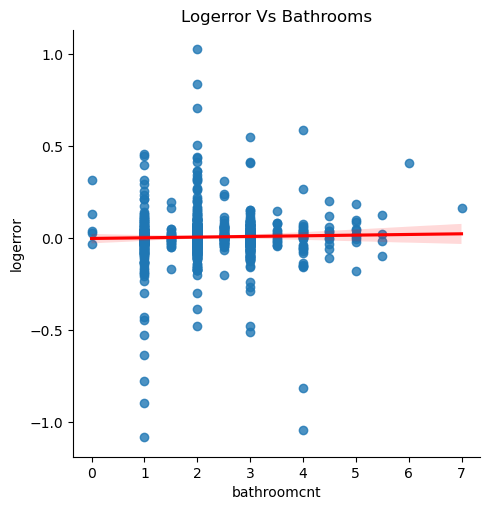

In [33]:
sns.lmplot(x='bathroomcnt', y='logerror', data=train.sample(1000), scatter=True, line_kws={'color': 'red'})
plt.title('Logerror Vs Bathrooms')
plt.show()

### Are logerror and year built correlated?

In [45]:
corr, p = stats.pearsonr(train.bathroomcnt, train.logerror)
corr, p

(0.02897821559780813, 1.606480594604058e-09)

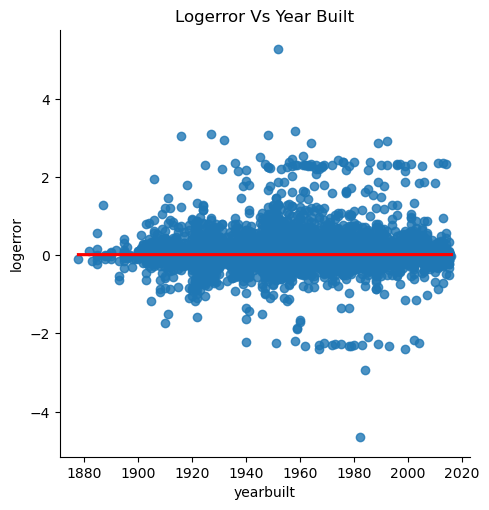

In [39]:
sns.lmplot(x='yearbuilt', y='logerror', data=train, scatter=True, line_kws={'color': 'red'})
plt.title('Logerror Vs Year Built')
plt.show()

### Are logerror and total sqft correlated?

In [46]:
corr, p = stats.pearsonr(train.bathroomcnt, train.logerror)
corr, p

(0.02897821559780813, 1.606480594604058e-09)

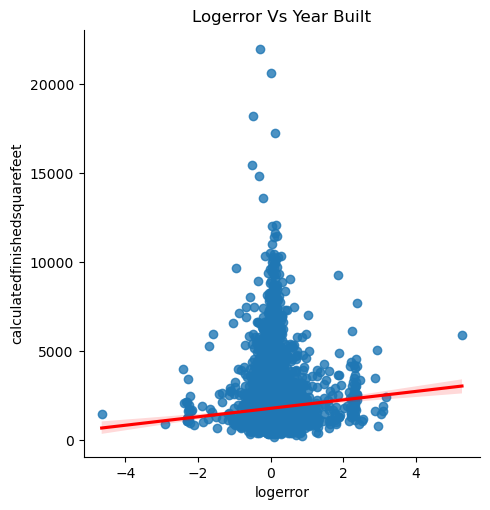

In [41]:

sns.lmplot(x='logerror', y='calculatedfinishedsquarefeet', data=train, scatter=True, line_kws={'color': 'red'})
plt.title('Logerror Vs Year Built')
plt.show()